In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import torch
from stable_diffusion3 import UniLatentPipeline, retrieve_timesteps
from diffusers import StableDiffusion3Pipeline as OGStableDiffusion3Pipeline

from diffusion.data.builder import build_dataset, build_dataloader
from diffusion.utils.data_sampler import AspectRatioBatchSampler
from torch.utils.data import RandomSampler

from tqdm import tqdm
from diffusers import get_cosine_schedule_with_warmup
from accelerate import Accelerator
from transformers import (
    GPT2Tokenizer,
    CLIPVisionModel,
    CLIPImageProcessor,
)

from caption_decoder import TextDecoder

# pipe = OGStableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3-medium-diffusers")#, torch_dtype=torch.float32)

# # text_decoder = TextDecoder.from_pretrained('/mnt/bn/us-aigc-temp/henry/unilatent_weights/gpt/', 
# #                     device_map=None, low_cpu_mem_usage=False, torch_dtype=torch.float32, ignore_mismatched_sizes=True)
# # slightly hacky -- cannot save wte weights since they are shared with lm_head, so we copy them back here
# # text_decoder.transformer.transformer.wte.weight = text_decoder.transformer.lm_head.weight
# # text_decoder.decode_prefix = torch.nn.Linear(1024, 768)
# decoder_tokenizer = GPT2Tokenizer.from_pretrained('/mnt/bn/us-aigc-temp/henry/unilatent_weights/gpt_tokenizer/')
# decoder_tokenizer.add_special_tokens({'pad_token': decoder_tokenizer.eos_token})
# pipe.decoder_tokenizer = decoder_tokenizer

# text_decoder = TextDecoder(prefix_length=257, prefix_inner_dim=1024, vocab_size=decoder_tokenizer.vocab_size + 1)
# pipe.text_decoder = text_decoder

# pipe.clip_image_encoder = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float32)
# pipe.clip_image_processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float32)

# pipe = UniLatentPipeline(
#     transformer=pipe.transformer,
#     scheduler=pipe.scheduler,
#     vae=pipe.vae,
#     text_encoder=pipe.text_encoder,
#     tokenizer=pipe.tokenizer,
#     text_encoder_2=pipe.text_encoder_2,
#     tokenizer_2=pipe.tokenizer_2,
#     clip_image_encoder=pipe.clip_image_encoder,
#     clip_image_processor=pipe.clip_image_processor,
#     text_decoder=pipe.text_decoder,
#     decoder_tokenizer=pipe.decoder_tokenizer,
# )

# pipe.save_pretrained(f'/mnt/bn/us-aigc-temp/henry/data/clip_test/')

/home/tiger/.local/lib/python3.9/site-packages/bytedmetrics/__init__.py:10: UserWarning: bytedmetrics is renamed to bytedance.metrics, please using `bytedance.metrics` instead of `bytedmetrics`
  warnings.warn("bytedmetrics is renamed to bytedance.metrics, please using `bytedance.metrics` instead of `bytedmetrics`")
/home/tiger/.local/lib/python3.9/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [3]:
pipe = UniLatentPipeline.from_pretrained('/mnt/bn/us-aigc-temp/henry/data/clip_test/', 
                    device_map=None, low_cpu_mem_usage=False, torch_dtype=torch.float32)
pipe.text_decoder = TextDecoder.from_pretrained('/mnt/bn/us-aigc-temp/henry/data/clip2text_2gpu/epoch_0_step_7499/', 
                        low_cpu_mem_usage=False, device_map=None)

<super: <class 'UniLatentPipeline'>, <UniLatentPipeline object>> ('/mnt/bn/us-aigc-temp/henry/data/clip_test/',) {'device_map': None, 'low_cpu_mem_usage': False, 'torch_dtype': torch.float32}


Loading pipeline components...:   0%|          | 0/11 [00:00<?, ?it/s]

Some weights of TextDecoder were not initialized from the model checkpoint at /mnt/bn/us-aigc-temp/henry/data/clip_test/text_decoder and are newly initialized: ['transformer.lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of TextDecoder were not initialized from the model checkpoint at /mnt/bn/us-aigc-temp/henry/data/clip2text_2gpu/epoch_0_step_7499/ and are newly initialized: ['transformer.lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
data_config = {
    'type': 'FlexibleInternalDataMS',
    'roots': [
        '/mnt/bn/us-aigc-temp/henry/coco_2014/val/val2014/',
        # '/mnt/bn/aigc-us/zjl/laion-coco-aesthetic/data_max1024/',
        # '/mnt/bn/aigc-us/zjl/openimages/data/',
        # '/mnt/bn/aigc-us/zjl/sharegpt4v_processed_data/data/'
    ],
    'json_lst': [
        '/mnt/bn/us-aigc-temp/henry/test.json',
    ],
    'load_vae_feat': False,
    'load_t5_feat': False
}
dataset = build_dataset(
    data_config, resolution=512, aspect_ratio_type='ASPECT_RATIO_512',
    real_prompt_ratio=0.0, max_length=77,
)
batch_sampler = AspectRatioBatchSampler(sampler=RandomSampler(dataset), dataset=dataset,
                                    batch_size=50, aspect_ratios=dataset.aspect_ratio, drop_last=True,
                                    ratio_nums=dataset.ratio_nums, valid_num=0)
dataloader = build_dataloader(dataset, batch_sampler=batch_sampler, num_workers=10)

2024-07-24 00:34:08,437 - PixArt - INFO - Constructing dataset FlexibleInternalDataMS...
2024-07-24 00:34:08,439 - PixArt - INFO - T5 max token length: 77
2024-07-24 00:34:08,439 - PixArt - INFO - ratio of real user prompt: 0.0
2024-07-24 00:34:08,484 - PixArt - INFO - /mnt/bn/us-aigc-temp/henry/test.json data volume: 5000
2024-07-24 00:34:08,507 - PixArt - INFO - Dataset FlexibleInternalDataMS constructed. time: 0.07 s, length (use/ori): 5000/5000
2024-07-24 00:34:08,508 - PixArt - WARNING - Using valid_num=0 in config file. Available 40 aspect_ratios: ['0.25', '0.26', '0.27', '0.28', '0.32', '0.33', '0.35', '0.4', '0.42', '0.48', '0.5', '0.52', '0.57', '0.6', '0.68', '0.72', '0.78', '0.82', '0.88', '0.94', '1.0', '1.07', '1.13', '1.21', '1.29', '1.38', '1.46', '1.67', '1.75', '2.0', '2.09', '2.4', '2.5', '2.89', '3.0', '3.11', '3.62', '3.75', '3.88', '4.0']


In [5]:
batch = next(iter(dataloader))

In [7]:
pipe = pipe.to('cuda')

In [8]:
image, prompt = batch[0].to('cuda'), batch[1]
batch[1] = [x.strip('<|endoftext|>') for x in batch[1]]
index = torch.randint(0, 1000, size=(len(image),))
loss = pipe.decode_loss(image, prompt, device='cuda', dtype=torch.float16)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

In [ ]:
from torch.nn.parallel import DistributedDataParallel as DDP
accelerator = Accelerator(
        mixed_precision='fp16',
    )

pipe.transformer = accelerator.prepare(pipe.transformer)
pipe.text_encoder, pipe.text_encoder_2 = accelerator.prepare(pipe.text_encoder, pipe.text_encoder_2)
pipe.clip_image_encoder, pipe.text_decoder = accelerator.prepare(pipe.clip_image_encoder, pipe.text_decoder)

In [19]:
iterloader = iter(dataloader)

In [35]:
batch = next(iterloader)

image_embd = pipe.encode_image(batch[0][:1], device=accelerator.device, dtype=torch.float16)
generate_captions = pipe.text_decoder.module.generate_captions if isinstance(pipe.text_decoder, DDP) else pipe.text_decoder.generate_captions
decoded_tokens = generate_captions(image_embd, 
                    eos_token_id=pipe.decoder_tokenizer.eos_token_id, device=accelerator.device)[0]
decoded_text = pipe.decoder_tokenizer.batch_decode(decoded_tokens)
print(decoded_text)
print(batch[1][0:1])

['<|endoftext|>A kitchen with a table and chairs in it. <|EOS|>']
['a dining room table that is in a room']


(-0.5, 447.5, 543.5, -0.5)

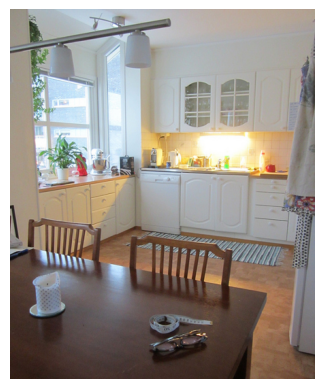

In [36]:
import matplotlib.pyplot as plt
plt.imshow((batch[0][:1] * .5 + .5)[0].permute(1, 2, 0).cpu().numpy())
plt.axis('off')